# Next character prediction (Text generation) in Nepali Language

## Importing the necessary libraries

In [2]:
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

## Experimentation with nepali text

In [111]:
nepali_text ='सामाजिक अध्ययन'
encoded_text = nepali_text.encode('utf-8')

letters = list(nepali_text)
letters_encoded = [letter.encode('utf-8') for letter in letters]
letters_as_bytes = list(encoded_text)

print("Letters of text")
print('----------------------------------------------------')
print(letters)
print()
print("UTF representations of each letter")
print('----------------------------------------------------')
print(letters_encoded)
print()
print("Byte representation of each letter")
print('----------------------------------------------------')
print( letters_as_bytes)

Letters of text
----------------------------------------------------
['स', 'ा', 'म', 'ा', 'ज', 'ि', 'क', ' ', 'अ', 'ध', '्', 'य', 'य', 'न']

UTF representations of each letter
----------------------------------------------------
[b'\xe0\xa4\xb8', b'\xe0\xa4\xbe', b'\xe0\xa4\xae', b'\xe0\xa4\xbe', b'\xe0\xa4\x9c', b'\xe0\xa4\xbf', b'\xe0\xa4\x95', b' ', b'\xe0\xa4\x85', b'\xe0\xa4\xa7', b'\xe0\xa5\x8d', b'\xe0\xa4\xaf', b'\xe0\xa4\xaf', b'\xe0\xa4\xa8']

Byte representation of each letter
----------------------------------------------------
[224, 164, 184, 224, 164, 190, 224, 164, 174, 224, 164, 190, 224, 164, 156, 224, 164, 191, 224, 164, 149, 32, 224, 164, 133, 224, 164, 167, 224, 165, 141, 224, 164, 175, 224, 164, 175, 224, 164, 168]


## Character Tokenizer

In [85]:
class CharacterTokenizer:
  def __init__(self):
    self.char_map = {}
    self.vocab = {}
    self.inverse_vocab = {}

  def train(self, text):
    # utf-8 encoded
    encoded_bytes = text.encode('utf-8')

    chars = sorted(set(list(text)))

    self.char_map = {char: char.encode('utf-8') for char in chars}

    self.vocab = {char: idx for idx, char in enumerate(chars)}
    self.inverse_vocab = {idx: char for idx, char in enumerate(chars)}

  def encode(self,text):
    output = [self.vocab[char] for char in text]
    return output

  def decode(self, output):
    output = [self.inverse_vocab[idx] for idx in output]
    output = ''.join(output)
    return output

## Trial of the Character Tokenizer

In [86]:
nepali_text ='सामाजिक अध्ययन'

tokenizer = CharacterTokenizer()
tokenizer.train(nepali_text)

temp = tokenizer.encode(nepali_text)
print(tokenizer.decode(temp))

{' ': 0, 'अ': 1, 'क': 2, 'ज': 3, 'ध': 4, 'न': 5, 'म': 6, 'य': 7, 'स': 8, 'ा': 9, 'ि': 10, '्': 11}
{0: ' ', 1: 'अ', 2: 'क', 3: 'ज', 4: 'ध', 5: 'न', 6: 'म', 7: 'य', 8: 'स', 9: 'ा', 10: 'ि', 11: '्'}
सामाजिक अध्ययन


## Model definition (LSTM)

In [87]:
class MyRNN(nn.Module):
  def __init__(self, embedding_size, hidden_size, vocab_size):
    super(MyRNN, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    emb = self.embedding(x) # [ B, Seq_L, Emb_S]
    out, _ = self.lstm(emb) # [B, Seq_L, hidden_size]
    out = out[:,-1,:] # [B, hidden_size]
    out = self.fc(out) # [B, vocab_size]
    return out

## Input from file

In [88]:
with open('nepali_text.txt', 'r') as file:
    raw_text = file.read()

In [89]:
tokenizer = CharacterTokenizer()
tokenizer.train(raw_text)

encoded = tokenizer.encode(raw_text)

{'\t': 0, '\n': 1, ' ': 2, '"': 3, 'ँ': 4, 'ं': 5, 'ः': 6, 'अ': 7, 'आ': 8, 'इ': 9, 'ई': 10, 'उ': 11, 'ऋ': 12, 'ए': 13, 'क': 14, 'ख': 15, 'ग': 16, 'घ': 17, 'ङ': 18, 'च': 19, 'छ': 20, 'ज': 21, 'झ': 22, 'ट': 23, 'ठ': 24, 'ड': 25, 'ढ': 26, 'ण': 27, 'त': 28, 'थ': 29, 'द': 30, 'ध': 31, 'न': 32, 'प': 33, 'फ': 34, 'ब': 35, 'भ': 36, 'म': 37, 'य': 38, 'र': 39, 'ल': 40, 'व': 41, 'श': 42, 'ष': 43, 'स': 44, 'ह': 45, 'ा': 46, 'ि': 47, 'ी': 48, 'ु': 49, 'ू': 50, 'ृ': 51, 'े': 52, 'ै': 53, 'ो': 54, 'ौ': 55, '्': 56}
{0: '\t', 1: '\n', 2: ' ', 3: '"', 4: 'ँ', 5: 'ं', 6: 'ः', 7: 'अ', 8: 'आ', 9: 'इ', 10: 'ई', 11: 'उ', 12: 'ऋ', 13: 'ए', 14: 'क', 15: 'ख', 16: 'ग', 17: 'घ', 18: 'ङ', 19: 'च', 20: 'छ', 21: 'ज', 22: 'झ', 23: 'ट', 24: 'ठ', 25: 'ड', 26: 'ढ', 27: 'ण', 28: 'त', 29: 'थ', 30: 'द', 31: 'ध', 32: 'न', 33: 'प', 34: 'फ', 35: 'ब', 36: 'भ', 37: 'म', 38: 'य', 39: 'र', 40: 'ल', 41: 'व', 42: 'श', 43: 'ष', 44: 'स', 45: 'ह', 46: 'ा', 47: 'ि', 48: 'ी', 49: 'ु', 50: 'ू', 51: 'ृ', 52: 'े', 53: 'ै', 54: 'ो', 55: 'ौ

In [90]:
seq_len = 10

X = []
y = []

for i in range(len(encoded)- seq_len):
  X.append(encoded[i:i+seq_len])
  y.append(encoded[i+seq_len])

In [91]:
X = torch.tensor(X)
y = torch.tensor(y)

print(X.shape)
print(y.shape)

torch.Size([3743, 10])
torch.Size([3743])


In [92]:
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [100]:
model = MyRNN(embedding_size=64, hidden_size=128, vocab_size=len(tokenizer.vocab))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training

In [101]:
num_epochs = 100
loss_list = []

for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        logits = model(batch_x)

        loss = criterion(logits, batch_y)
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

Epoch 1 Loss: 3.2211
Epoch 2 Loss: 2.5238
Epoch 3 Loss: 2.5068
Epoch 4 Loss: 2.1125
Epoch 5 Loss: 2.3044
Epoch 6 Loss: 1.7710
Epoch 7 Loss: 1.9344
Epoch 8 Loss: 1.5016
Epoch 9 Loss: 1.5473
Epoch 10 Loss: 1.1847
Epoch 11 Loss: 1.1533
Epoch 12 Loss: 0.8756
Epoch 13 Loss: 1.0829
Epoch 14 Loss: 1.2424
Epoch 15 Loss: 0.9148
Epoch 16 Loss: 0.7279
Epoch 17 Loss: 0.8277
Epoch 18 Loss: 0.6024
Epoch 19 Loss: 0.8489
Epoch 20 Loss: 0.4546
Epoch 21 Loss: 0.3297
Epoch 22 Loss: 0.6889
Epoch 23 Loss: 0.4229
Epoch 24 Loss: 0.5207
Epoch 25 Loss: 0.2734
Epoch 26 Loss: 0.1696
Epoch 27 Loss: 0.3692
Epoch 28 Loss: 0.3055
Epoch 29 Loss: 0.2252
Epoch 30 Loss: 0.1500
Epoch 31 Loss: 0.2529
Epoch 32 Loss: 0.1593
Epoch 33 Loss: 0.2338
Epoch 34 Loss: 0.1305
Epoch 35 Loss: 0.1974
Epoch 36 Loss: 0.0991
Epoch 37 Loss: 0.1929
Epoch 38 Loss: 0.1157
Epoch 39 Loss: 0.0605
Epoch 40 Loss: 0.1052
Epoch 41 Loss: 0.1338
Epoch 42 Loss: 0.0294
Epoch 43 Loss: 0.0245
Epoch 44 Loss: 0.1814
Epoch 45 Loss: 0.1064
Epoch 46 Loss: 0.07

## Training Plot

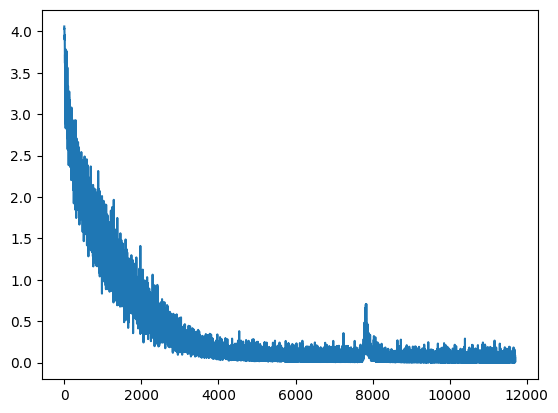

In [102]:
plt.plot(loss_list)

## Generation of characters function definition

In [103]:
def generate(model, tokenizer, text, length):

    model.eval()

    tokens = tokenizer.encode(text)
    print("The length of the tokens is :: ",len(tokens))

    for i in range(length):
        input_seq = tokens[-seq_len:]
        input_tensor = torch.tensor([input_seq])

        with torch.no_grad():
            logits = model(input_tensor)
            next_token = torch.argmax(logits, dim=-1).item()
            tokens.append(next_token)

    return tokenizer.decode(tokens)

## Generation

In [104]:
new_text = generate(model, tokenizer, "अध्ययन", 50)
print(new_text)

The length of the tokens is ::  6
अध्ययनका दिया अर्य बैंकले चालेका कदमपछि सुधार देखिन सुरु
